<img src="Local\imgs\U1\banner_fcd.jpg" alt="banner" width="1100"  height="150">

# <span style="color:black;"><strong>Técnicas de detección de atípicos</strong></span>  
---
<p align="right">
  <a href="https://colab.research.google.com/github/mariabda2/intro_data_2025/blob/main/FCD_U3_deteccion_atipicos_iqr_zscore.ipynb?clone=true" target="_blank">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Abrir en Colab"/>
  </a>
</p>

## <span style="color:#2F749F;"><strong>🎯 Objetivos de aprendizaje</strong></span>

> ✅ Comprender el concepto de **dato atípico** y su importancia en el análisis estadístico y en proyectos de ciencia de datos.  
>  
> ✅ Identificar y aplicar diferentes **técnicas de detección de atípicos** en datos univariados y multivariados (gráficas, métodos estadísticos y enfoques basados en modelos).  
>  
> ✅ Analizar el impacto de los atípicos en la **calidad de los modelos predictivos y descriptivos**, evaluando riesgos y sesgos asociados.  
>  
> ✅ Desarrollar criterios para decidir **cuándo corregir, transformar o conservar los datos atípicos**, según el contexto y los objetivos del análisis.  
>  
> ✅ Implementar métodos de detección de atípicos en **ejercicios prácticos con Python**, fortaleciendo la capacidad de limpiar y preparar datos de forma crítica.  


## <span style="color:#2F749F;"><strong>Contenido</strong></span>

1. **Métodos estadísticos**  
   - Rango intercuartílico (IQR)  
   - Puntaje Z (Z-Score)  

2. **Técnicas de visualización**  
   - Boxplot  
   - Scatter plot  

3. **Pruebas estadísticas**  
   - Test de Grubbs  
   - DBSCAN  

4. **Técnicas de aprendizaje automático**  
   - Isolation Forest  
   - Local Outlier Factor (LOF)  


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy import stats
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from matplotlib.patches import Circle
from sklearn.neighbors import NearestNeighbors

sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (18, 5)
np.random.seed(42)

In [75]:
# Simulación de datos con outliers
normal_data = np.random.normal(loc=50, scale=10, size=100)
outliers = np.array([10, 120, 130])
data = np.concatenate([normal_data, outliers])
df = pd.DataFrame({'valor': data})

# <span style="color:#2F749F;"><strong>1. Método del Rango Intercuartílico (IQR)</strong></span>

El **IQR (Interquartile Range)** es una medida robusta de dispersión introducida por Tukey [(1977)](https://www.wiley.com/en-us/Exploratory+Data+Analysis-p-9780201076165).  
Se define como la diferencia entre el tercer cuartil \(Q_3\) y el primer cuartil \(Q_1\):

$$
\mathrm{IQR} = Q_3 - Q_1
$$

Un valor se considera atípico si se ubica fuera del rango:

$$
\left[\, Q_1 - 1.5\cdot\mathrm{IQR}, \;\; Q_3 + 1.5\cdot\mathrm{IQR} \,\right]
$$



<div style="background-color:#fff9db; padding:10px; border-radius:5px; font-size:18px;">
  <b>Este enfoque es simple, robusto frente a distribuciones asimétricas, pero menos eficaz en entornos multivariados. 
  Es recomendable complementarlo con otros métodos y con criterios contextuales antes de tomar decisiones sobre los datos atípicos.</b>
</div>

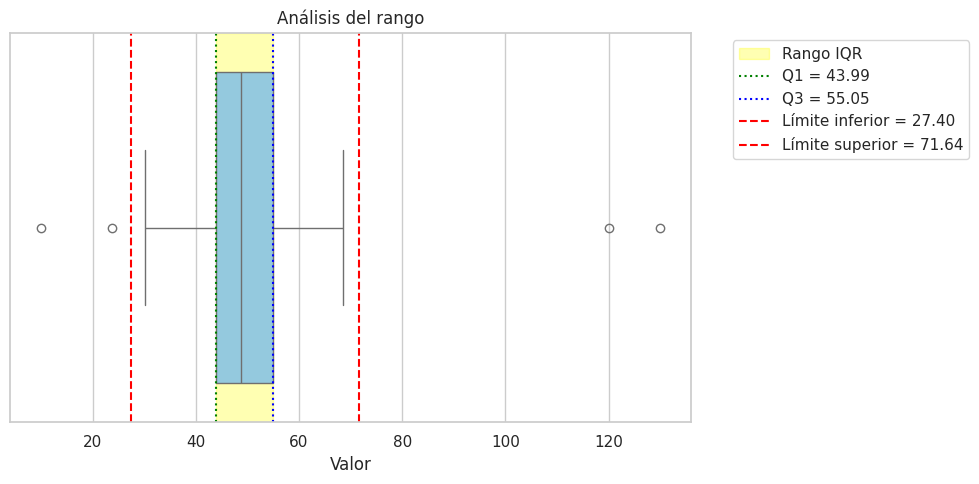

In [76]:
# Cálculo de IQR
Q1 = df['valor'].quantile(0.25)
Q3 = df['valor'].quantile(0.75)
IQR = Q3 - Q1
lim_inf = Q1 - 1.5 * IQR
lim_sup = Q3 + 1.5 * IQR
df['outlier_iqr'] = (df['valor'] < lim_inf) | (df['valor'] > lim_sup)

plt.figure(figsize=(10,5))
sns.boxplot(x=df['valor'], color='skyblue')
plt.axvspan(Q1, Q3, color='yellow', alpha=0.3, label='Rango IQR')
plt.axvline(Q1, color='green', linestyle=':', label=f'Q1 = {Q1:.2f}')
plt.axvline(Q3, color='blue', linestyle=':', label=f'Q3 = {Q3:.2f}')
plt.axvline(lim_inf, color='red', linestyle='--', label=f'Límite inferior = {lim_inf:.2f}')
plt.axvline(lim_sup, color='red', linestyle='--', label=f'Límite superior = {lim_sup:.2f}')

plt.xlabel('Valor')
plt.title('Análisis del rango')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<div style="background-color:#e8f4fd; padding:15px; border-radius:8px; font-size:17px;">

<b>Importante (IQR):</b>

- **Sensibilidad al tamaño de muestra**: con conjuntos de datos pequeños, la estimación de los cuartiles puede ser inestable y afectar la detección de atípicos.  
- **Eficiencia en distribuciones no normales**: el IQR es robusto frente a sesgos y asimetrías, pero puede identificar como atípicos valores que en realidad son parte natural de una distribución sesgada.  
- **Umbral fijo (1.5 × IQR)**: el factor de 1.5 es convencional, pero no universal. Ajustar este valor puede ser necesario en contextos específicos (ej. usar 3 × IQR en datos muy dispersos).  
- **No captura relaciones multivariadas**: un valor puede no ser atípico en una sola variable, pero sí al considerar varias variables de manera conjunta. El IQR no detecta este tipo de casos.  
- **Interpretación contextual**: no todo valor extremo es necesariamente un error; algunos pueden reflejar fenómenos reales importantes (ej. un rendimiento académico excepcional).  

</div>

# <span style="color:#2F749F;"><strong>2. Método del Puntaje Z (Z-Score)</strong></span>

El **Z-score** indica la distancia en desviaciones estándar de un valor respecto a la media, siendo ampliamente descrito en Barnett y Lewis [(1994)](https://onlinelibrary.wiley.com/doi/book/10.1002/9781118490082).  
Para un valor \(x\):

$$
Z = \frac{x - \mu}{\sigma}
$$

Se considera atípico si:

$$
|Z| > k
$$

donde típicamente \(k = 3\). 

<div style="background-color:#fff9db; padding:10px; border-radius:5px; font-size:18px;">
  <b>Este método es apropiado cuando los datos se aproximan a una distribución normal, 
  pero puede verse afectado por la presencia de valores extremos o asimetrías que alteran 
  significativamente la media y la desviación estándar.</b><br>
</div>




       valor   z_score      media   desv_est
0  54.967142  0.183503  51.701918  17.793796
1  48.617357 -0.173350  51.701918  17.793796
2  56.476885  0.268350  51.701918  17.793796
3  65.230299  0.760286  51.701918  17.793796
4  47.658466 -0.227239  51.701918  17.793796
5  47.658630 -0.227230  51.701918  17.793796
6  65.792128  0.791861  51.701918  17.793796
7  57.674347  0.335647  51.701918  17.793796
8  45.305256 -0.359488  51.701918  17.793796
9  55.425600  0.209269  51.701918  17.793796


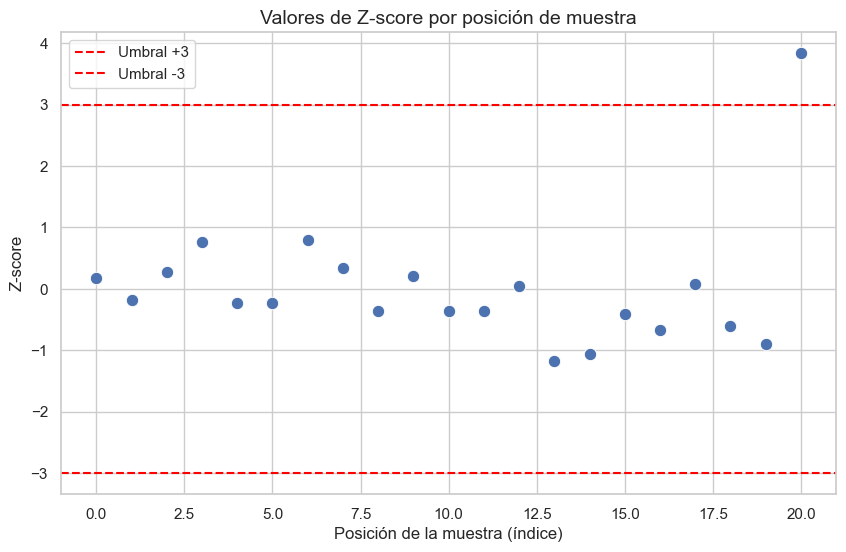

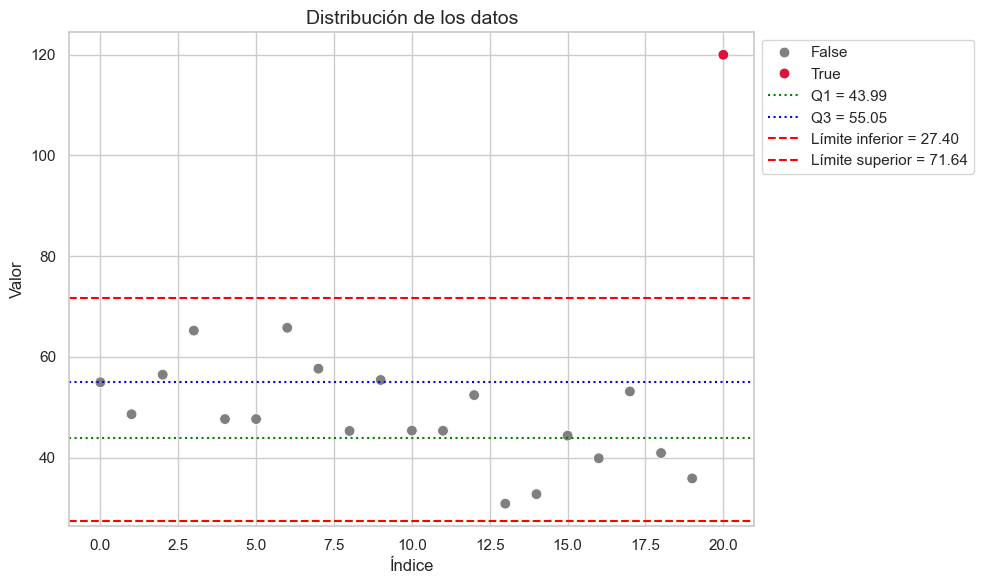

In [82]:
# Calcular Z score
df['z_score'] = zscore(df['valor'])
df['outlier_z'] = df['z_score'].abs() > 3

# Media y desviación estándar global
mu = df['valor'].mean()
sigma = df['valor'].std(ddof=0)

# Calcular z-score 
df['z_score'] = (df['valor'] - mu) / sigma

# Mostrar n muestras 
tabla_muestra = df[['valor', 'z_score']].head(10)
tabla_muestra['media'] = mu
tabla_muestra['desv_est'] = sigma
print(tabla_muestra)

# Crear scatter plot
plt.figure(figsize=(10,6))
sns.scatterplot(x=np.arange(len(df['z_score'])), y=df['z_score'], s=80)

# Líneas horizontales en ±3 (umbral típico de outliers)
plt.axhline(y=3, color='red', linestyle='--', label='Umbral +3')
plt.axhline(y=-3, color='red', linestyle='--', label='Umbral -3')

plt.title("Valores de Z-score por posición de muestra", fontsize=14)
plt.xlabel("Posición de la muestra (índice)", fontsize=12)
plt.ylabel("Z-score", fontsize=12)
plt.legend(loc="upper left")
plt.show()


# Figura
plt.figure(figsize=(10,6))
sns.scatterplot(
    x=range(len(df)), 
    y='valor', 
    hue='outlier_z', 
    data=df,
    palette={False: 'gray', True: 'crimson'}, 
    s=60
)

plt.axhline(Q1, color='green', linestyle=':', label=f'Q1 = {Q1:.2f}')
plt.axhline(Q3, color='blue', linestyle=':', label=f'Q3 = {Q3:.2f}')
plt.axhline(lim_inf, color='red', linestyle='--', label=f'Límite inferior = {lim_inf:.2f}')
plt.axhline(lim_sup, color='red', linestyle='--', label=f'Límite superior = {lim_sup:.2f}')

plt.title('Distribución de los datos', fontsize=14)
plt.xlabel('Índice', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()




<div style="background-color:#e8f4fd; padding:15px; border-radius:8px; font-size:17px;">

<b>Importante (Z-Score):</b>

- **Dependencia de la distribución normal**: el Z-Score funciona mejor cuando los datos se aproximan a una distribución normal; en distribuciones sesgadas puede fallar en la detección.  
- **Sensibilidad a valores extremos**: los atípicos influyen en la media y en la desviación estándar, lo que puede distorsionar el cálculo de los Z-Scores.  
- **Umbral convencional (|Z| > 3)**: este valor es una regla general; sin embargo, puede ajustarse (ej. usar 2.5 o 4) dependiendo del contexto y del nivel de tolerancia a los atípicos.  
- **Escalado y estandarización**: el método requiere que los datos estén estandarizados para que las comparaciones sean válidas.  
- **Interpretación contextual**: un valor con |Z| elevado no siempre es un error; puede representar un comportamiento excepcional o un fenómeno de interés (ej. un estudiante con rendimiento sobresaliente).  

</div>


# <span style="color:#2F749F;"><strong>3. Test de Grubbs </strong></span>

El **Test de Grubbs**, desarrollado en un trabajo clásico de Grubbs [(1969)](https://www.tandfonline.com/doi/abs/10.1080/00401706.1969.10490657), permite evaluar si el valor más extremo de una muestra corresponde a un outlier bajo el supuesto de normalidad.  
Se define como:

$$
G = \max \left( \frac{|x_i - \bar{x}|}{s} \right)
$$

Donde:

- \( X_i \): valor observado más extremo (mínimo o máximo)  
- \( \bar{X} \): media de la muestra  
- \( s \): desviación estándar de la muestra  

El valor calculado de \(G\) se compara con un valor crítico \(G_{crit}\) de tablas específicas según el tamaño de la muestra y el nivel de significancia [(Ver tabla)](https://webspace.ship.edu/pgmarr/Geo441/Tables/Grubbs%20G%20Outlier%20Test.pdf).

Si \( G > G_{crit} \), el valor extremo se considera atípico.

<div style="background-color:#fff9db; padding:10px; border-radius:5px; font-size:18px;">

<b>Este test es útil para muestras pequeñas con distribución normal, 
pero debe aplicarse con cautela en presencia de múltiples atípicos o datos que no cumplen 
los supuestos de normalidad.</b><br>

</div>


Valor extremo: 120.00
G calculado: 3.746
G crítico: 2.734
¿Es outlier según Grubbs? Sí


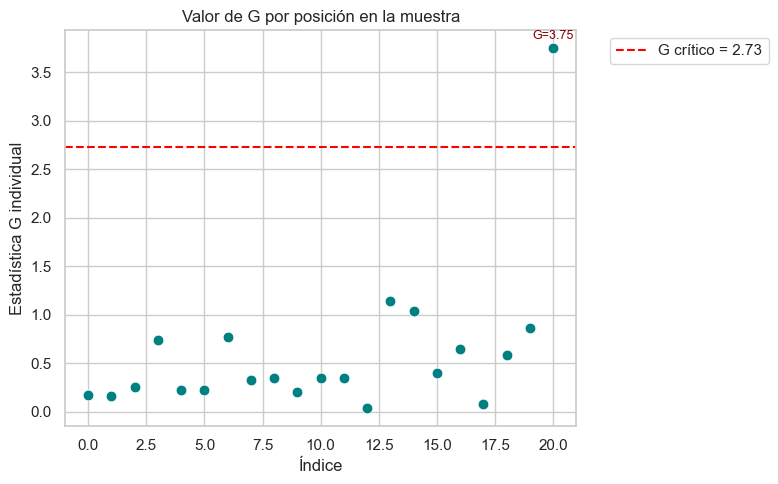

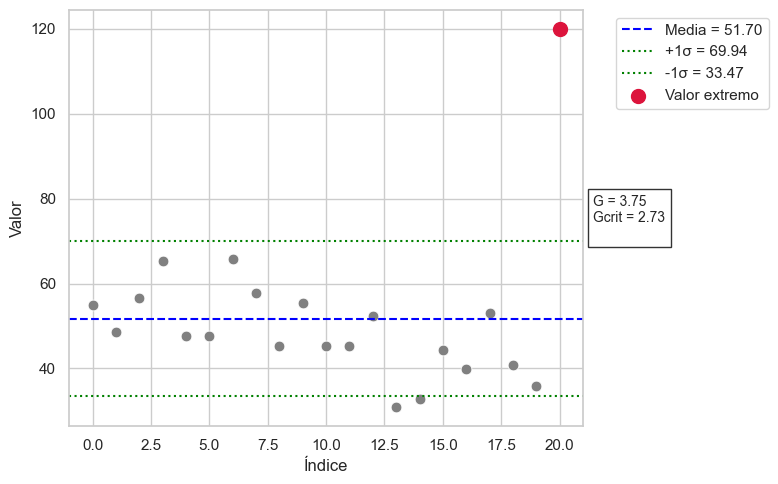

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Configuración estética
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (8, 5)
np.random.seed(42)

# Simulación de datos
data = np.append(np.random.normal(loc=50, scale=10, size=20), 120)
df = pd.DataFrame({'valor': data})

# Estadísticos generales
media = np.mean(data)
std = np.std(data, ddof=1)
n = len(data)

# Cálculo de G para el valor más extremo
extremo = data[np.argmax(np.abs(data - media))]
G = np.abs(extremo - media) / std

# Valor crítico G_crit (nivel de significancia 0.05, dos colas)
t = stats.t.ppf(1 - 0.05 / (2 * n), n - 2)
G_crit = ((n - 1) / np.sqrt(n)) * np.sqrt(t**2 / (n - 2 + t**2))

# Resultado
es_outlier = G > G_crit
print(f"Valor extremo: {extremo:.2f}")
print(f"G calculado: {G:.3f}")
print(f"G crítico: {G_crit:.3f}")
print(f"¿Es outlier según Grubbs? {'Sí' if es_outlier else 'No'}")

# Cálculo de G para cada punto
G_por_indice = np.abs(data - media) / std

plt.figure()
sns.scatterplot(x=range(n), y=G_por_indice, color='teal', s=60)
plt.axhline(G_crit, color='red', linestyle='--', label=f'G crítico = {G_crit:.2f}')

# Anotar puntos con G > 2
for i, g in enumerate(G_por_indice):
    if g > 2:
        plt.text(i, g + 0.1, f"G={g:.2f}", color='darkred', fontsize=9, ha='center')

plt.title('Valor de G por posición en la muestra')
plt.xlabel('Índice')
plt.ylabel('Estadística G individual')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure()
sns.scatterplot(x=range(n), y='valor', data=df, color='gray', s=60)
plt.axhline(media, color='blue', linestyle='--', label=f'Media = {media:.2f}')
plt.axhline(media + std, color='green', linestyle=':', label=f'+1σ = {media + std:.2f}')
plt.axhline(media - std, color='green', linestyle=':', label=f'-1σ = {media - std:.2f}')
plt.scatter(np.argmax(np.abs(data - media)), extremo, color='crimson', s=100, label='Valor extremo')

plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.text(1.02, 0.5,
         f"G = {G:.2f}\nGcrit = {G_crit:.2f}\n",
         transform=plt.gca().transAxes,
         fontsize=10,
         bbox=dict(facecolor='white', edgecolor='black', alpha=0.8),
         verticalalignment='center')
plt.tight_layout()
plt.show()




<div style="background-color:#e8f4fd; padding:15px; border-radius:8px; font-size:17px;">

<b>Importante (Test de Grubbs):</b>

- Requiere que los datos provengan de una **distribución normal**.  
- Diseñado para detectar **un solo atípico por prueba**; si se sospechan múltiples, se deben aplicar versiones iterativas.  
- Es más confiable en **muestras pequeñas o moderadas**, donde otros métodos pueden perder sensibilidad.  
- Puede ser menos adecuado en grandes bases de datos o con distribuciones no normales.  

</div>



# <span style="color:#2F749F;"><strong>4. Método DBSCAN</strong></span>

El algoritmo **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**, propuesto por Ester et al. [(1996)](https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf), identifica clústeres de alta densidad y clasifica como outliers a los puntos que no pertenecen a ninguno.  
Un punto \(p\) es **central** si tiene al menos `minPts` vecinos dentro de un radio (ε):

$$
N_\varepsilon(p) = \{\, q \in D \;|\; \mathrm{dist}(p,q) \leq \varepsilon \,\}
$$

El algoritmo depende de dos parámetros clave:  

- **ε (epsilon):** radio máximo de vecindad.  
- **`minPts`** número mínimo de puntos requeridos para formar un clúster.  

DBSCAN es eficaz en datos multivariados, aunque su desempeño depende críticamente de la correcta selección de (ε) y `minPts`.

DBSCAN separa los puntos en tres categorías:  

- **Núcleo (core points):** puntos con suficientes vecinos en un radio definido.  
- **Borde (border points):** puntos cercanos a los núcleos, pero con menos vecinos.  
- **Ruido (outliers):** puntos que no pertenecen a ningún clúster.

Los puntos que no tienen al menos `minPts` vecinos dentro de un radio (ε) se consideran **atípicos o ruido**.  


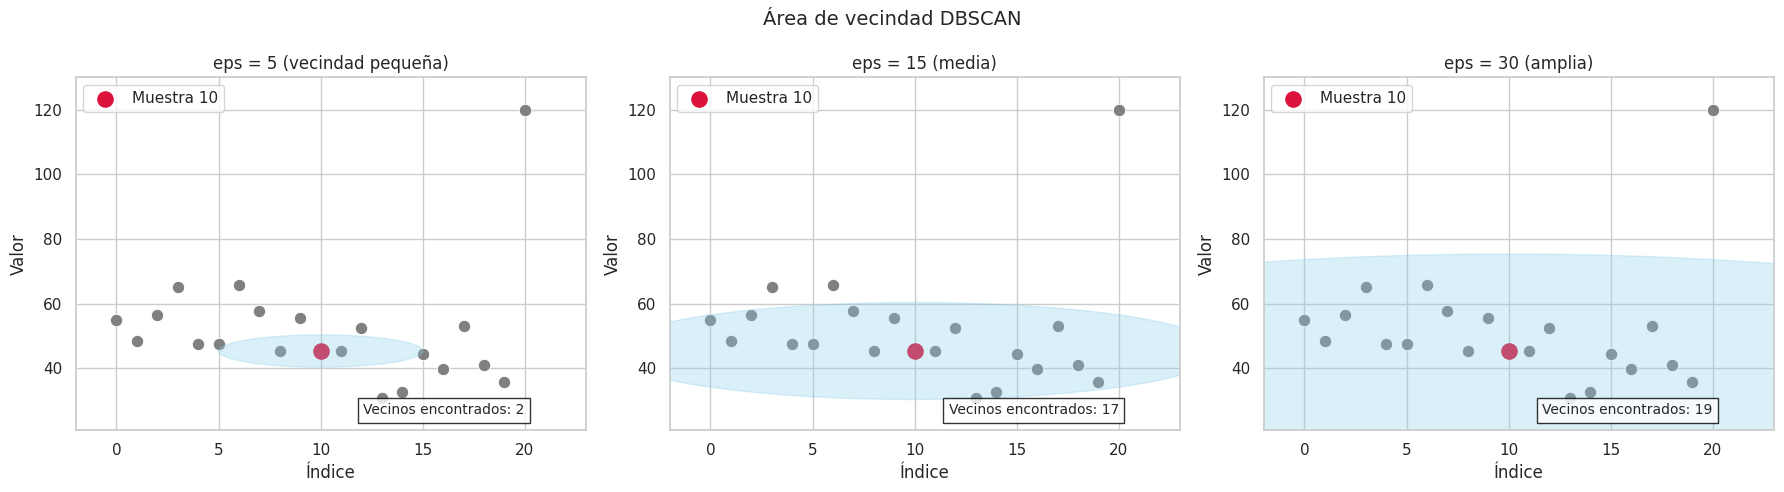

In [79]:
# Configuración visual
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (18, 5)
np.random.seed(42)

# Datos
data = np.append(np.random.normal(loc=50, scale=10, size=20), 120)
X = np.column_stack([range(len(data)), data])  # índice vs valor
punto_central = X[10]  # muestra número 10

# Comparación
epsilons = [5, 15, 30]
titulos = ['eps = 5 (vecindad pequeña)', 'eps = 15 (media)', 'eps = 30 (amplia)']

# Graficas
fig, axes = plt.subplots(1, 3)

for i, eps in enumerate(epsilons):
    ax = axes[i]
    sns.scatterplot(x=X[:, 0], y=X[:, 1], ax=ax, s=80, color='gray')
    ax.scatter(*punto_central, color='crimson', s=120, label='Muestra 10')

    # vecindad
    circulo = Circle(punto_central, eps, color='skyblue', alpha=0.3)
    ax.add_patch(circulo)

    # vecinos dentro del círculo
    distancias = np.linalg.norm(X - punto_central, axis=1)
    vecinos = np.sum(distancias <= eps) - 1  # excluye el punto central

    ax.set_title(titulos[i])
    ax.set_xlabel('Índice')
    ax.set_ylabel('Valor')
    ax.set_xlim(-2, len(data) + 2)
    ax.set_ylim(min(data) - 10, max(data) + 10)
    ax.text(len(data) - 1, min(data) - 5,
            f"Vecinos encontrados: {vecinos}",
            fontsize=10,
            ha='right',
            bbox=dict(facecolor='white', edgecolor='black', alpha=0.8))
    ax.legend(loc='upper left')

plt.suptitle('Área de vecindad DBSCAN', fontsize=14)
plt.tight_layout()
plt.show()


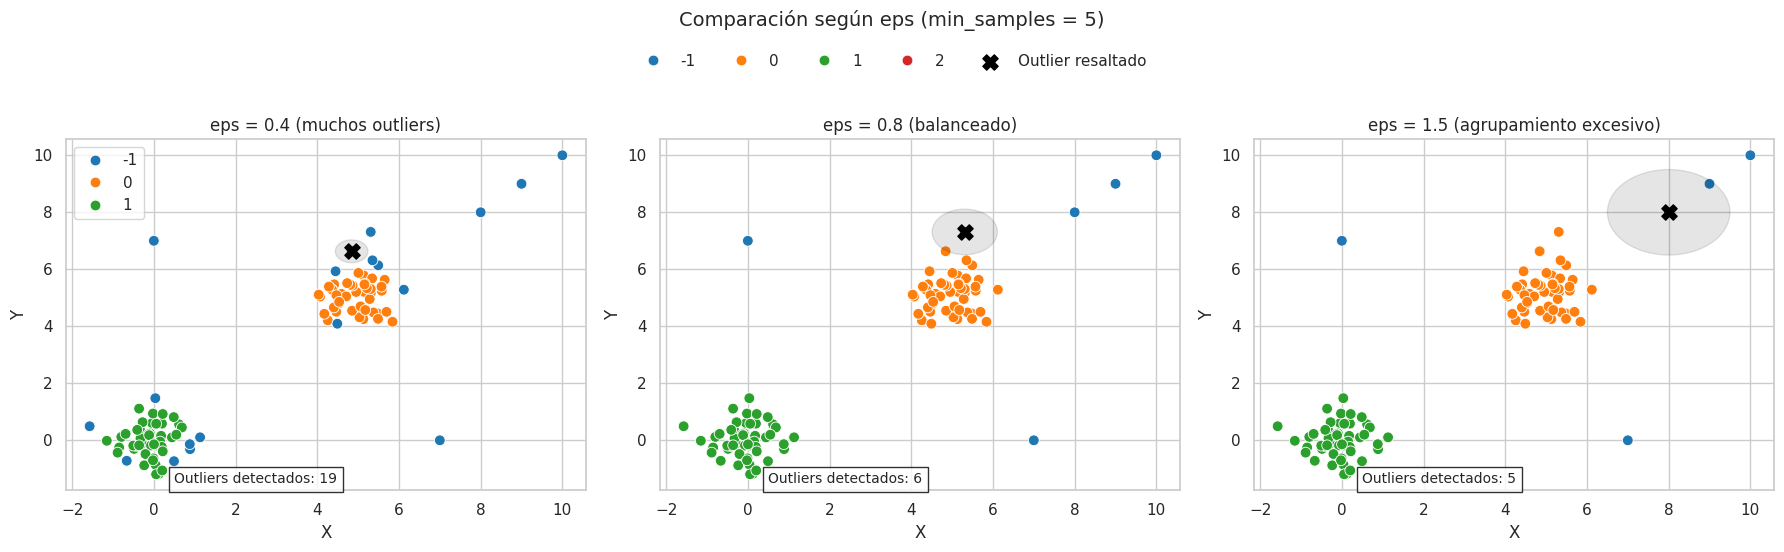

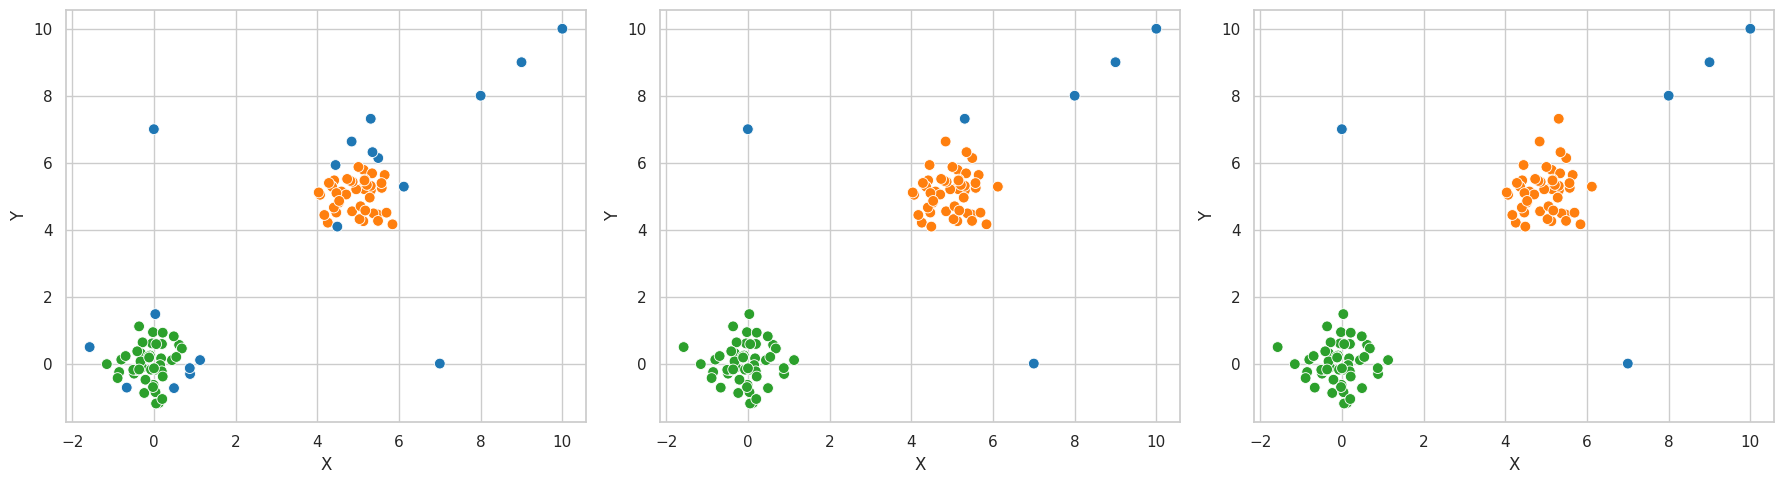

In [80]:
# Simulación de datos 
centros = [[0, 0], [5, 5]]
X, _ = make_blobs(n_samples=100, centers=centros, cluster_std=0.6)
outliers = np.array([[8, 8], [9, 9], [10, 10], [0, 7], [7, 0]])
X_total = np.vstack([X, outliers])

# Valores de eps
epsilons = [0.4, 0.8, 1.5]
titulos = ['eps = 0.4 (muchos outliers)', 'eps = 0.8 (balanceado)', 'eps = 1.5 (agrupamiento excesivo)']

# Graficar
fig, axes = plt.subplots(1, 3)
for i, eps in enumerate(epsilons):
    modelo = DBSCAN(eps=eps, min_samples=5)
    etiquetas = modelo.fit_predict(X_total)

    # Graficar con leyenda solo en el primer subplot
    sns.scatterplot(x=X_total[:, 0], y=X_total[:, 1], hue=etiquetas,
                    palette='tab10', s=60, ax=axes[i], legend=(i == 0))

    # Sombra sobre un outlier con radio = eps
    outlier_indices = np.where(etiquetas == -1)[0]
    if len(outlier_indices) > 0:
        idx = outlier_indices[0]
        punto = X_total[idx]
        sombra = Circle(punto, radius=eps, color='black', alpha=0.1)
        axes[i].add_patch(sombra)
        axes[i].scatter(*punto, color='black', s=120, marker='X', label='Outlier resaltado')

    axes[i].set_title(titulos[i])
    axes[i].set_xlabel('X')
    axes[i].set_ylabel('Y')
    axes[i].text(0.5, -1.5,
                 f"Outliers detectados: {(etiquetas == -1).sum()}",
                 fontsize=10,
                 ha='left',
                 bbox=dict(facecolor='white', edgecolor='black', alpha=0.8))


plt.suptitle('Comparación según eps (min_samples = 5)', fontsize=14, y=1.10)
leg = fig.legend(handles, labels,
                 title='',
                 loc='upper center',
                 bbox_to_anchor=(0.5, 1.04),
                 ncol=len(set(labels)))
leg.set_frame_on(False)

plt.tight_layout()
plt.show()

# Graficar sin sombra [Todos los datos]
fig, axes = plt.subplots(1, 3)

for i, eps in enumerate(epsilons):
    modelo = DBSCAN(eps=eps, min_samples=5)
    etiquetas = modelo.fit_predict(X_total)

    sns.scatterplot(x=X_total[:, 0], y=X_total[:, 1], hue=etiquetas,
                    palette='tab10', s=60, ax=axes[i], legend=False)

    #axes[i].set_title(titulos[i])
    axes[i].set_xlabel('X')
    axes[i].set_ylabel('Y')
plt.tight_layout()
plt.show()


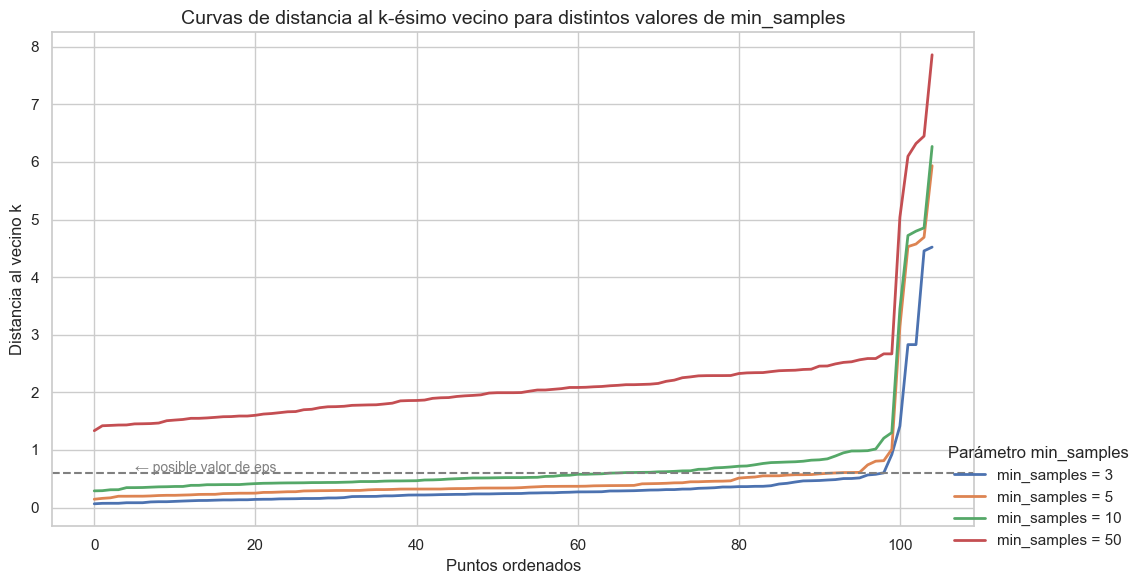

In [ ]:
fig = plt.figure(figsize=(10, 6))

# Simulación de datos
np.random.seed(42)
centros = [[0, 0], [5, 5]]
X, _ = make_blobs(n_samples=100, centers=centros, cluster_std=0.6)
outliers = np.array([[8, 8], [9, 9], [10, 10], [0, 7], [7, 0]])
X_total = np.vstack([X, outliers])

# Valores de min_samples a comparar
vecinos_k = [3, 5, 10, 50]

for k in vecinos_k:
    modelo = NearestNeighbors(n_neighbors=k)
    modelo.fit(X_total)
    distancias, _ = modelo.kneighbors(X_total)
    
    # Tomar la distancia al k-ésimo vecino más cercano
    distancia_k = np.sort(distancias[:, -1])
    plt.plot(distancia_k, label=f'min_samples = {k}', linewidth=2)

# Estética del gráfico
plt.title('Curvas de distancia al k-ésimo vecino para distintos valores de min_samples', fontsize=14)
plt.xlabel('Puntos ordenados')
plt.ylabel('Distancia al vecino k')
plt.grid(True)
leg = fig.legend(title='Parámetro min_samples',
                 loc='lower right',
                 bbox_to_anchor=(1.15, 0.05),  # fuera del gráfico
                 frameon=False)
plt.axhline(y=0.6, color='gray', linestyle='--', label='Ejemplo de eps = 0.6')
plt.text(5, 0.62, '← posible valor de eps', fontsize=10, color='gray')
plt.tight_layout()
plt.show()



<div style="background-color:#e8f4fd; padding:15px; border-radius:8px; font-size:17px;">

<b>Importante (DBSCAN):</b>

- No requiere especificar el número de clústeres previamente.  
- Detecta atípicos de manera natural al clasificar los puntos de baja densidad como ruido.  
- Es robusto frente a distribuciones no esféricas y datos con formas arbitrarias.  
- La calidad de la detección depende en gran medida de la elección de los parámetros **ε** y **MinPts**.  
- Puede tener dificultades en datasets con densidades variables o en muy altas dimensiones.  

</div>


# <span style="color:#2F749F;"><strong>5. Isolation Forest</strong></span>

El **Isolation Forest**, introducido por Liu, Ting y Zhou [(2008)](https://ieeexplore.ieee.org/document/4781136), se fundamenta en el principio de que los outliers son más fáciles de **aislar** que los puntos normales.  
El algoritmo construye múltiples árboles de aislamiento aleatorio, y la longitud promedio del camino para un punto sirve como indicador: los valores atípicos tienden a tener **caminos más cortos**.  
Es altamente escalable, eficiente en grandes volúmenes de datos y adecuado para alta dimensionalidad.


# <span style="color:#2F749F;"><strong>6. Local Outlier Factor (LOF)</strong></span>

El **Local Outlier Factor (LOF)**, propuesto por Breunig, Kriegel, Ng y Sander [(2000)](https://dl.acm.org/doi/10.1145/342009.335388), detecta anomalías a partir de la **densidad relativa local**.  
Un punto se considera outlier si su densidad es significativamente menor que la de sus vecinos:

- Los puntos en regiones de baja densidad relativa reciben un LOF alto → considerados outliers.  
- Los puntos en regiones homogéneas → LOF cercano a 1 → considerados normales.

LOF es especialmente útil en contextos donde la densidad varía en diferentes regiones del espacio de datos.


---

<div style="text-align:center; color:#607D8B; font-weight:bold; font-size:14px;">
“Sin datos, solo eres otra persona con una opinión.” – W. Edwards Deming
</div>